In [21]:
# Dependencies
import requests
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.stats import ttest_ind
import hvplot.pandas

# Import U.S. Census API Key
from config import api_key

In [2]:
c = Census(
    api_key,
    year = 2013
)
c

In [3]:
# Dictionary mapping state codes to state names
state_mapping = {
    '01': 'Alabama',
    '02': 'Alaska',
    '04': 'Arizona',
    '05': 'Arkansas',
    '06': 'California',
    '08': 'Colorado',
    '09': 'Connecticut',
    '10': 'Delewarre',
    '11': 'District of Colombia',
    '12': 'Florida',
    '13': 'Georgia',
    '15': 'Hawaii',
    '16': 'Idaho',
    '17': 'Illinois',
    '18': 'Indiana',
    '19': 'Iowa',
    '20': 'Kansas',
    '21': 'Kentucky',
    '22': 'Louisiana',
    '23': 'Maine',
    '24': 'Maryland',
    '25': 'Massachusetts',
    '26': 'Michigan',
    '27': 'Minnesota',
    '28': 'Mississippi',
    '29': 'Missouri',
    '30': 'Montana',
    '31': 'Nebraska',
    '32': 'Nevada',
    '33': 'New Hampshire',
    '34': 'New Jersey',
    '35': 'New Mexico',
    '36': 'New York',
    '37': 'North Carolina',
    '38': 'North Dakota',
    '39': 'Ohio',
    '40': 'Oklahoma',
    '41': 'Oregon',
    '42': 'Pennsylvania',
    '44': 'Rhode Island',
    '45': 'South Carolina',
    '46': 'South Dakota',
    '47': 'Tennessee',
    '48': 'Texas',
    '49': 'Utah',
    '50': 'Vermont',
    '51': 'Washington',
    '54': 'West Virginia',
    '55': 'Wisconsin',
    '56': 'Wyoming',
    '72': 'Puerto Rico'
}

census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B19301_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "Name",
        "zip code tabulation area": "Zipcode"
    }
)

# Replace numeric state codes with state names
census_pd['State'] = census_pd['state'].map(state_mapping)

# Add a Poverty Rate column (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd

Number of rows in the DataFrame: 33120


,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,state,Zipcode,State,Poverty Rate
0,ZCTA5 01832,57833.0,22121.0,38.5,29014.0,2412.0,25,01832,Massachusetts,10.903666
1,ZCTA5 01833,107775.0,8295.0,42.4,43297.0,191.0,25,01833,Massachusetts,2.302592
2,ZCTA5 01834,97463.0,6675.0,46.1,40222.0,146.0,25,01834,Massachusetts,2.187266
3,ZCTA5 01835,72228.0,13527.0,37.1,31429.0,1153.0,25,01835,Massachusetts,8.523693
4,ZCTA5 01840,18261.0,4547.0,36.8,14758.0,1798.0,25,01840,Massachusetts,39.542556
...,...,...,...,...,...,...,...,...,...,...
33115,ZCTA5 99923,21944.0,81.0,64.3,17225.0,4.0,02,99923,Alaska,4.938272
33116,ZCTA5 99925,38125.0,668.0,46.4,25094.0,124.0,02,99925,Alaska,18.562874
33117,ZCTA5 99926,50052.0,1630.0,31.4,22850.0,202.0,02,99926,Alaska,12.392638
33118,ZCTA5 99927,19000.0,111.0,59.4,21157.0,39.0,02,99927,Alaska,35.135135


In [25]:
# Empty dictionary to store aggregated data for each state
aggregated_data = {}

# Iterate through each row in the DataFrame
for index, row in census_pd.iterrows():
    state = row["State"]
    population = int(row["Population"])
    poverty_count = int(row["Poverty Count"])
    
    # Update aggregated data for the state
    if state in aggregated_data:
        aggregated_data[state]["Population"] += population
        aggregated_data[state]["Poverty Count"] += poverty_count
    else:
        aggregated_data[state] = {
            "Population": population,
            "Poverty Count": poverty_count
        }


# Create a DataFrame for aggregated data
aggregated_df = pd.DataFrame(aggregated_data).transpose()
aggregated_df.reset_index(inplace=True)
aggregated_df.rename(columns={"index": "State"}, inplace=True)

# Recalculate poverty rate for each state
aggregated_df["Poverty Rate"] = 100 * aggregated_df["Poverty Count"].astype(int) / aggregated_df["Population"].astype(int)
#aggregated_df["Poverty Rate"] = aggregated_df["Poverty Rate"].apply(lambda x: '{:.2f}%'.format(x))

# Rearrange columns
aggregated_df["Population"] = aggregated_df["Population"].apply(lambda x: '{:,}'.format(x))
aggregated_df["Poverty Count"] = aggregated_df["Poverty Count"].apply(lambda x: '{:,}'.format(x))
aggregated_df = aggregated_df.sort_values(by="State")

# Save the aggregated DataFrame as a CSV
aggregated_df.to_csv("CSV Files/aggregated_census_data.csv", encoding="utf-8")

aggregated_df.head()

,State,Population,Poverty Count,Poverty Rate
21,Alabama,"4,799,220","870,631",18.141094
51,Alaska,"719,805","69,414",9.643445
44,Arizona,"6,482,040","1,132,517",17.471614
37,Arkansas,"2,933,423","547,402",18.660861
47,California,"37,650,435","5,885,402",15.631697


In [59]:
# Load the maternal mortality data
maternal_mortality_df = pd.read_csv("CSV Files/maternal_mortality.csv")

# Merge the two DataFrames on the "State" column
combined_df = pd.merge(aggregated_df, maternal_mortality_df, on="State", how="left")

# Rearrange columns
combined_df = combined_df[["State", "Population", "Poverty Count", "Poverty Rate", "Pregnancies", "Deaths", "Maternal Mortality Rate"]]
combined_df = combined_df.dropna(axis=0, how="any")

# Save the combined DataFrame as a CSV
combined_df.to_csv("CSV Files/combined_census_mortality_data.csv", index=False)

combined_df

,State,Population,Poverty Count,Poverty Rate,Pregnancies,Deaths,Maternal Mortality Rate
0,Alabama,"4,799,220","870,631",18.141094,"231,884.06",96,41.4
2,Arizona,"6,482,040","1,132,517",17.471614,"315,286.62",99,31.4
3,Arkansas,"2,933,423","547,402",18.660861,"144,827.59",63,43.5
4,California,"37,650,435","5,885,402",15.631697,"1,742,574.26",176,10.1
5,Colorado,"5,119,400","660,895",12.909618,"250,000.00",38,15.2
6,Connecticut,"3,583,561","354,348",9.888153,"137,724.55",23,16.7
9,Florida,"19,091,069","3,052,802",15.990734,"866,920.15",228,26.3
10,Georgia,"9,809,871","1,736,677",17.703362,"498,525.07",169,33.9
13,Illinois,"12,848,544","1,772,333",13.794038,"549,132.95",95,17.3
14,Indiana,"6,514,519","969,794",14.886655,"321,543.41",100,31.1


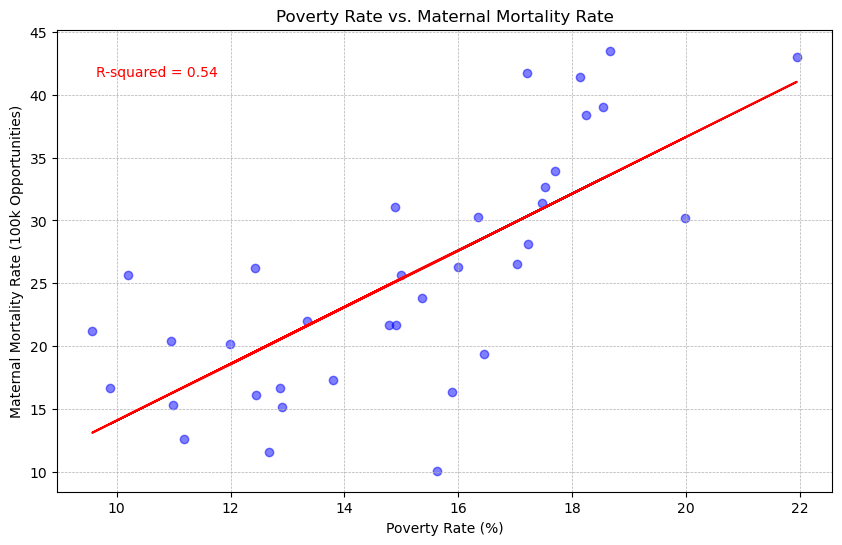

In [27]:
#plot poverty rate vs maternal mortality rate with fit line
# Convert poverty rate and maternal mortality rate to numeric values
combined_df['Poverty Rate'] = combined_df['Poverty Rate'].astype('float')
combined_df['Maternal Mortality Rate'] = combined_df['Maternal Mortality Rate'].astype('float')


plt.figure(figsize=(10, 6))
plt.scatter(combined_df['Poverty Rate'], combined_df['Maternal Mortality Rate'], color='blue', alpha=0.5)
plt.title('Poverty Rate vs. Maternal Mortality Rate')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Maternal Mortality Rate (100k Opportunities)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Display gridlines for both major and minor ticks

slope, intercept, r_value, p_value, std_err = linregress(combined_df['Poverty Rate'], combined_df['Maternal Mortality Rate'])
fit_line = slope * combined_df['Poverty Rate'] + intercept
r_squared = r_value ** 2  # Calculate R-squared value
plt.plot(combined_df['Poverty Rate'], fit_line, color='red', label=f'Fit Line (R-squared = {r_squared:.2f})')
plt.text(0.05, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes, color='red')

# Save the figure
plt.savefig("Output Data/02 Scatterplot Line Fit.png")

plt.show()

In [28]:
combined_df = combined_df.sort_values(by='Poverty Rate')
num_rows = len(combined_df)
split_index = num_rows // 2
combined_df['State Poverty'] = ['rich'] * split_index + ['poor'] * (num_rows - split_index)
combined_df.head()


,State,Population,Poverty Count,Poverty Rate,Pregnancies,Deaths,Maternal Mortality Rate,State Poverty
20,Maryland,"5,834,284","558,329",9.569795,"278,301.89",59,21.2,rich
6,Connecticut,"3,583,561","354,348",9.888153,"137,724.55",23,16.7,rich
30,New Jersey,"8,832,393","900,583",10.196365,"400,778.21",103,25.7,rich
47,Washington,"8,100,652","887,638",10.957612,"338,235.29",69,20.4,rich
21,Massachusetts,"6,605,053","725,351",10.981759,"274,509.80",42,15.3,rich


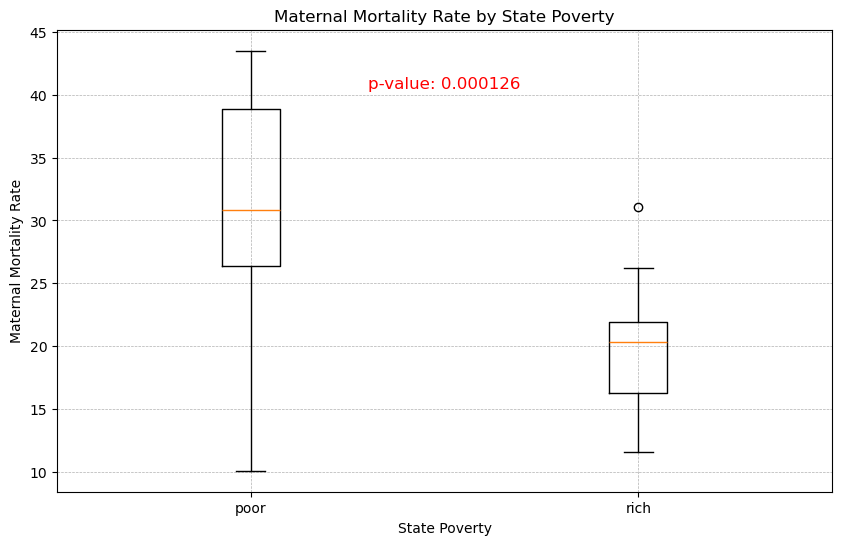

In [29]:
# Create a boxplot of poor vs rich state vs mortality rates
# Group the data by State Poverty
grouped_data = combined_df.groupby('State Poverty')['Maternal Mortality Rate'].apply(list)
grouped_data

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data.values, labels=grouped_data.index)
plt.title('Maternal Mortality Rate by State Poverty')
plt.xlabel('State Poverty')
plt.ylabel('Maternal Mortality Rate')
plt.grid(True, linestyle='--', linewidth=0.5)  # Add gridlines for better readability

#perform t-test
rich_mortality = combined_df[combined_df['State Poverty'] == 'rich']['Maternal Mortality Rate']
poor_mortality = combined_df[combined_df['State Poverty'] == 'poor']['Maternal Mortality Rate']
t_statistic, p_value = ttest_ind(rich_mortality, poor_mortality)

# Annotate the plot with the p-value
plt.text(1.5, max(combined_df['Maternal Mortality Rate']) - 3, f'p-value: {p_value:.6f}', fontsize=12, ha='center', color='red')

# Save the figure
plt.savefig("Output Data/03 Boxplot.png")

plt.show()

In [30]:
election_data = pd.read_csv("CSV Files/2020 Popular Vote.csv", converters={'Voted': lambda x: x.replace('D', 'Democratic').replace('R', 'Republican')})
combined_df = pd.merge(combined_df, election_data[['State', 'Voted']], on='State', how='left')

combined_df.head()
                                                 

,State,Population,Poverty Count,Poverty Rate,Pregnancies,Deaths,Maternal Mortality Rate,State Poverty,Voted
0,Maryland,"5,834,284","558,329",9.569795,"278,301.89",59,21.2,rich,Democratic
1,Connecticut,"3,583,561","354,348",9.888153,"137,724.55",23,16.7,rich,Democratic
2,New Jersey,"8,832,393","900,583",10.196365,"400,778.21",103,25.7,rich,Democratic
3,Washington,"8,100,652","887,638",10.957612,"338,235.29",69,20.4,rich,Democratic
4,Massachusetts,"6,605,053","725,351",10.981759,"274,509.80",42,15.3,rich,Democratic
5,Minnesota,"5,347,612","598,376",11.189593,"261,904.76",33,12.6,rich,Democratic
6,Iowa,"3,063,159","367,462",11.996178,"148,514.85",30,20.2,rich,Republican
7,Nebraska,"1,841,883","228,794",12.421744,"99,236.64",26,26.2,rich,Republican
8,Utah,"2,812,781","349,878",12.438864,"186,335.40",30,16.1,rich,Republican
9,Wisconsin,"5,706,893","723,732",12.681717,"250,000.00",29,11.6,rich,Democratic


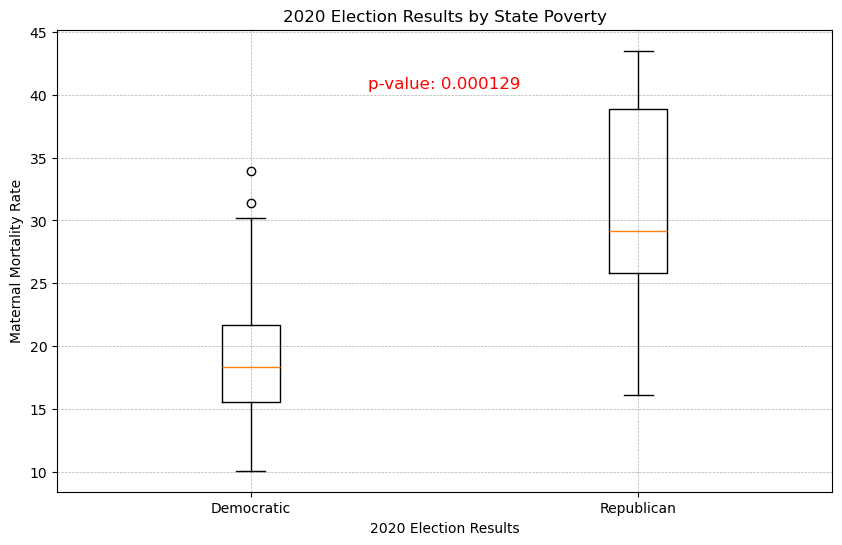

In [31]:
# Group the data by State Poverty
grouped_data = combined_df.groupby('Voted')['Maternal Mortality Rate'].apply(list)
grouped_data

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data.values, labels=grouped_data.index)
plt.title('2020 Election Results by State Poverty')
plt.xlabel('2020 Election Results')
plt.ylabel('Maternal Mortality Rate')
plt.grid(True, linestyle='--', linewidth=0.5)  # Add gridlines for better readability

#perform t-test
democratic_mortality = combined_df[combined_df['Voted'] == 'Democratic']['Maternal Mortality Rate']
republican_mortality = combined_df[combined_df['Voted'] == 'Republican']['Maternal Mortality Rate']
t_statistic, p_value = ttest_ind(democratic_mortality, republican_mortality)

# Annotate the plot with the p-value
plt.text(1.5, max(combined_df['Maternal Mortality Rate']) - 3, f'p-value: {p_value:.6f}', fontsize=12, ha='center', color='red')

# Save the figure
plt.savefig("Output Data/04 Political Boxplot.png")

plt.show()

AttributeError: 'LineString' object has no attribute 'plot'

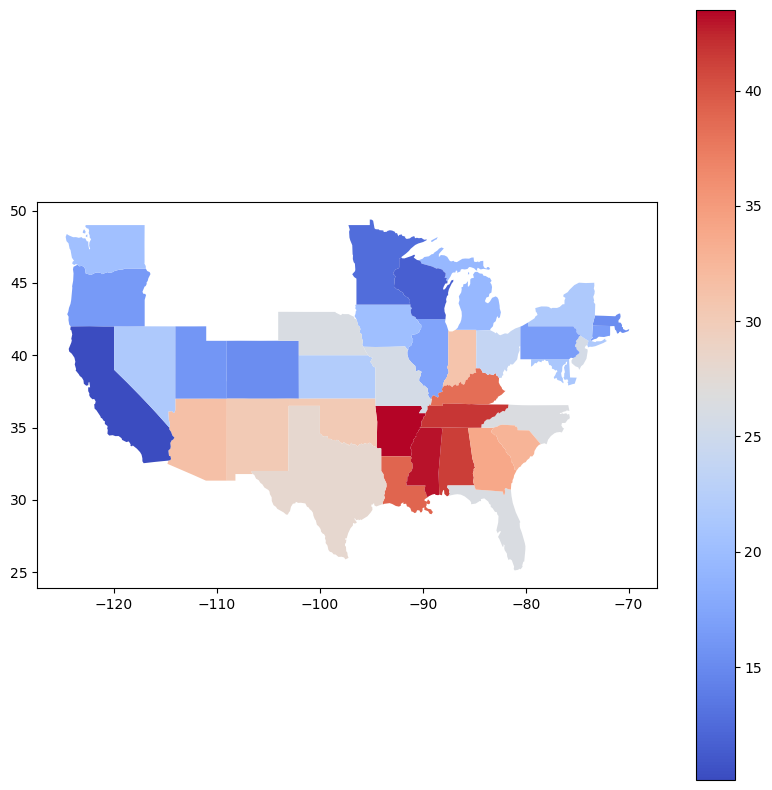

In [58]:
# Read the GeoJSON file
geojson_file = "CSV Files/mapgeo.json"
gdf = gpd.read_file(geojson_file)


# Merge GeoDataFrame with combined_df on State column
gdf_merged = gdf.merge(combined_df, how='left', left_on='name', right_on='State')

# Plot the map and color it based on the 'Maternal Mortality Rate' column
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_merged.plot(ax=ax, cmap='coolwarm', column='Maternal Mortality Rate', legend=True,z
                vmin=gdf_merged['Maternal Mortality Rate'].min(), vmax=gdf_merged['Maternal Mortality Rate'].max())

# Color the states with Maternal Mortality Rate greater than 25 as red and less than 25 as blue
for index, row in gdf_merged.iterrows():
    if row['Maternal Mortality Rate'] > 25:
        gdf_merged.loc[index, 'geometry'].boundary.plot(ax=ax, color="red", linewidth=2)
    else:
        gdf_merged.loc[index, 'geometry'].boundary.plot(ax=ax, color="blue", linewidth=2)

# Add title and labels
ax.set_title('Maternal Mortality Rate by State')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()